## XGBoost.dt - Dutch only


In [5]:
import xgboost as xgb
import pandas as pd
import numpy as np
import sklearn

In [6]:
tweets = pd.read_excel("../../Data/tweets.xlsx")
tweets = tweets[tweets['GR'] != 'unclear']
tweets

,Tweet_id,text_clean,GR,iaa
0,1,ik heb 13u aan een stuk gewerkt come at me,neutral,0.579270
1,2,Olive Garden - SNL,neutral,0.556808
2,3,"Jozef De Kesel wordt zondag kardinaal: ""Ik kij...",positive,0.613758
3,4,mijn wifi SUCKT echt en ik kant niemeer aan,negative,1.000000
4,5,Gedraag je maar als een hoe,negative,0.464437
...,...,...,...,...
2995,2996,Kheb mij gisterenavond best wel goe gehad 😌,positive,1.000000
2996,2997,Blij dat ze zich aan de charter houden! #homo...,positive,0.518596
2997,2998,Ik mis mijn fiets,negative,0.575348
2998,2999,Weer veel te laat naar bed. Dat ga ik morgenvr...,negative,1.000000


array([[<AxesSubplot:title={'center':'iaa'}>]], dtype=object)

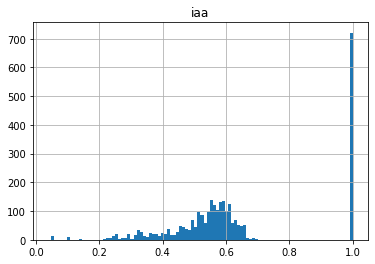

In [7]:
tweets.hist("iaa",bins= 100)

Check proportion of hard/easy tweets!

In [8]:
threshold = 0.62 # <--------------  ADJUST DIFFICULT TWEET THRESHOLD HERE
lables = tweets['iaa'] < threshold
tweets['difficult'] = tweets['iaa'] < threshold
print("There are " + str(tweets['difficult'].sum()) + " hard tweets in the current dataset." 
          " Which is " +  str(round(tweets['difficult'].sum()/len(tweets), ndigits = 3)*100) + "% of all tweets in the dataset")

There are 1933 hard tweets in the current dataset. Which is 66.2% of all tweets in the dataset


##Embedding

In [9]:
embedded_tweets = pd.read_pickle("../../Data/embedded_dutch_emoji_groupnr.pkl")

In [10]:
tweets["embeddings"] = embedded_tweets.tolist()

80/20 split

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tweets[["embeddings","Tweet_id"]],
                                                    lables.to_numpy(), test_size=0.2, 
                                                    random_state=42, stratify = lables.to_numpy())

In [12]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, 
                                                    y_train, test_size=0.15, 
                                                    random_state=42, stratify = y_train)

In [13]:
len(X_validation)

351

Test stratify() command

In [14]:
sum(y_test)/len(y_test)

0.6626712328767124

## XGBoost Model Creation

note: classification tree

In [15]:
total = len(tweets)
pos = tweets['difficult'].sum()
neg = total - pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

In [16]:
Tweets_XGB = xgb.XGBClassifier(objective= "binary:logistic", seed = 42 , scale_pos_weight = weight_for_1)

GridSearchCV to tune parameters (code taken from: https://www.kaggle.com/phunter/xgboost-with-gridsearchcv/script)

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_confusion_matrix

In [18]:
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.15,0.1,0.05], #so called `eta` value
              'max_depth': [4,5,6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [900,1000,1100], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}


In [19]:
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)
ftwo_scorer
make_scorer(fbeta_score, beta=2)

make_scorer(fbeta_score, beta=2)

In [20]:
Tweets_XGB_tuned = GridSearchCV(Tweets_XGB , 
                                parameters, 
                                n_jobs=5,  
                                scoring= "roc_auc", #also tried: recall, auc,...
                                verbose=1,
                                refit=True
                                ) # I dropped StratifiedKfold --> look into adding it again

Fit tree to training data

In [ ]:
Tweets_XGB_tuned.fit(np.stack(X_train["embeddings"]), # Adjust object if fitting works
                     y_train,
                     verbose = True,
                     early_stopping_rounds = 10,
                     eval_metric = "aucpr",
                     eval_set = [(np.stack(X_validation["embeddings"]), y_validation)]
                     )

In [23]:
Tweets_XGB_tuned.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 11,
 'missing': -999,
 'n_estimators': 900,
 'nthread': 4,
 'objective': 'binary:logistic',
 'seed': 1337,
 'silent': 1,
 'subsample': 0.8}

##Confusion Matrix

/Users/jbm/miniforge3/envs/tensorflow_text_base/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


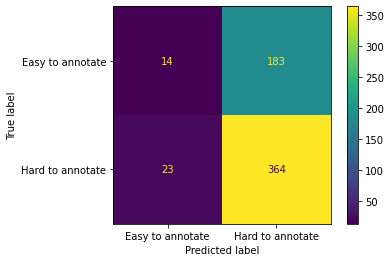

In [24]:
plot_confusion_matrix(Tweets_XGB_tuned, 
                      np.stack(X_test['embeddings']), 
                      y_test,
                      values_format= "d",
                      display_labels= ["Easy to annotate", "Hard to annotate"],
                      colorbar=True
                      )

In [25]:
y_pred = Tweets_XGB_tuned.predict(np.stack(X_test['embeddings']))
y_pred_raw = Tweets_XGB_tuned.predict_proba(np.stack(X_test['embeddings']))

In [26]:
from sklearn.metrics import fbeta_score
print("The F_beta score is " + str(round(fbeta_score(y_test, y_pred, average='weighted', beta=2), ndigits = 3)*100)+ "% (with a beta of 2)") 

The F_beta score is 60.4% (with a beta of 2)


#Precision-Recall Curve

In [27]:
# PR curve for XGBoost regression model
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn import metrics

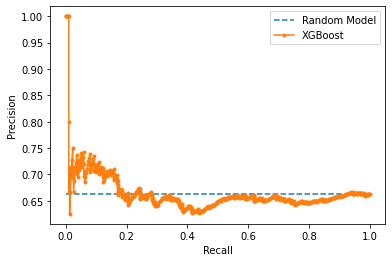

In [28]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_raw[:,1])
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='Random Model')
pyplot.plot(recall, precision, marker='.', label='XGBoost')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

##ROC Curve

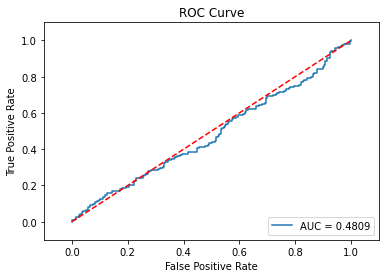

In [30]:
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_raw[:,1])

auc_score = metrics.auc(fpr, tpr)

# clear current figure
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.4f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

#Export Data

In [46]:
#df = pd.DataFrame({"Truth":y_test, "Pred":y_pred, "Prob": y_pred_raw[:,1]})

In [48]:
#df.to_csv("../../Data/resultsXGBoostDutch.csv")